In [96]:
import numpy as np

period = 0.8  
duration = 0.8
dt = 0.001 

P_LV_0 = 8.0 
P_AO_0 = 85.0 
P_SYS_0 = 0.0


R_C = 3.3e-5
R_LV= 7.9
C_LV = 0.875

C_AO = 0.1
R_SYS = 20

R_AO = 0.05

matrix_2 = np.array([
    [C_LV/dt + 1/R_LV,   0,         1,                   0],
    [-1/R_C,             1/R_C,     0,                   0],
    [0,                  0,        -1,     C_AO/dt+1/R_SYS],
    [1/R_AO,             0,        -1,             -1/R_AO]
])
matrix_inverse_2 = np.linalg.inv(matrix_2)



/Users/pengfei/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pengfei/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pengfei/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pengfei/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/pengfei/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missin

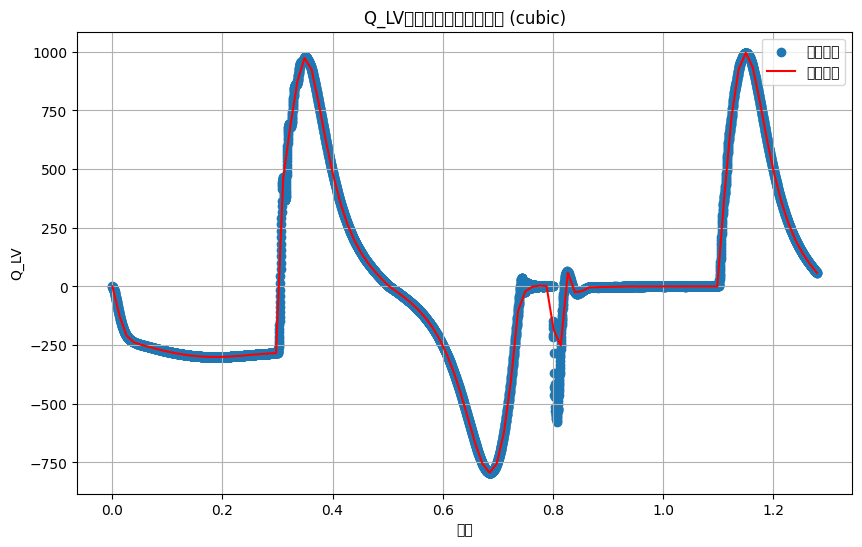

示例：
在t=0.001时，Q_LV = -4.034784244382195
在t=0.0015时(插值点)，Q_LV = -6.775080353728104


In [97]:

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# 读取CSV文件
def read_csv(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines[1:]:  # 跳过标题行
        parts = line.strip().split(',')
        data.append((int(parts[0]), float(parts[1])))
    return data

# 读取时间数据
time_data = read_csv('time.csv')  # 第一个CSV文件
# 读取Q_LV数据
q_lv_data = read_csv('truncated_LV_capacity.csv')  # 第二个CSV文件

# 提取步数和值
steps = np.array([x[0] for x in time_data])
time_values = np.array([x[1] for x in time_data])
q_lv_values = np.array([x[1] for x in q_lv_data])

# 提取步数和值
steps = np.array([x[0] for x in time_data])
time_values = np.array([x[1] for x in time_data])
q_lv_values = np.array([x[1] for x in q_lv_data])

# 使用interp1d创建插值函数
# kind可以是'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'等
fun_Q_LV = interp1d(time_values, q_lv_values, kind='cubic', fill_value="extrapolate")

# 绘制原始数据和插值曲线
plt.figure(figsize=(10, 6))
plt.scatter(time_values, q_lv_values, label='原始数据')
t_fit = np.linspace(min(time_values), max(time_values), 100)
plt.plot(t_fit, fun_Q_LV(t_fit), 'r-', label='插值曲线')
plt.xlabel('时间')
plt.ylabel('Q_LV')
plt.legend()
plt.title('Q_LV随时间变化的插值曲线 (cubic)')
plt.grid(True)
plt.show()

# 测试插值函数
print("示例：")
print(f"在t=0.001时，Q_LV = {fun_Q_LV(0.001)}")
print(f"在t=0.0015时(插值点)，Q_LV = {fun_Q_LV(0.0015)}")

In [98]:



def Windkessel_1(Q_LV, P_LV_1_n, dt):
    P_LV_1 = (C_LV*P_LV_1_n/dt+Q_LV)/(1/R_LV+C_LV/dt)
    P_LV = P_LV_1 + R_C*Q_LV
    return P_LV, P_LV_1

def Windkessel_2(P_AO_n, dt):
    P_AO = (-C_AO*P_AO_n/dt-P_SYS_0/R_SYS)/(-1/R_SYS-C_AO/dt)
    return P_AO

def Windkessel_3(Q_LV, P_LV_1_n, P_AO_n, dt):
    rhs = np.array([C_LV/dt*P_LV_1_n+Q_LV, Q_LV, C_AO/dt*P_AO_n+P_SYS_0/R_SYS,0])
    result = np.dot(matrix_inverse_2, rhs)
    P_LV_1, P_LV, Q_AO, P_AO = result.flatten()
    return P_LV_1, P_LV, Q_AO, P_AO


    

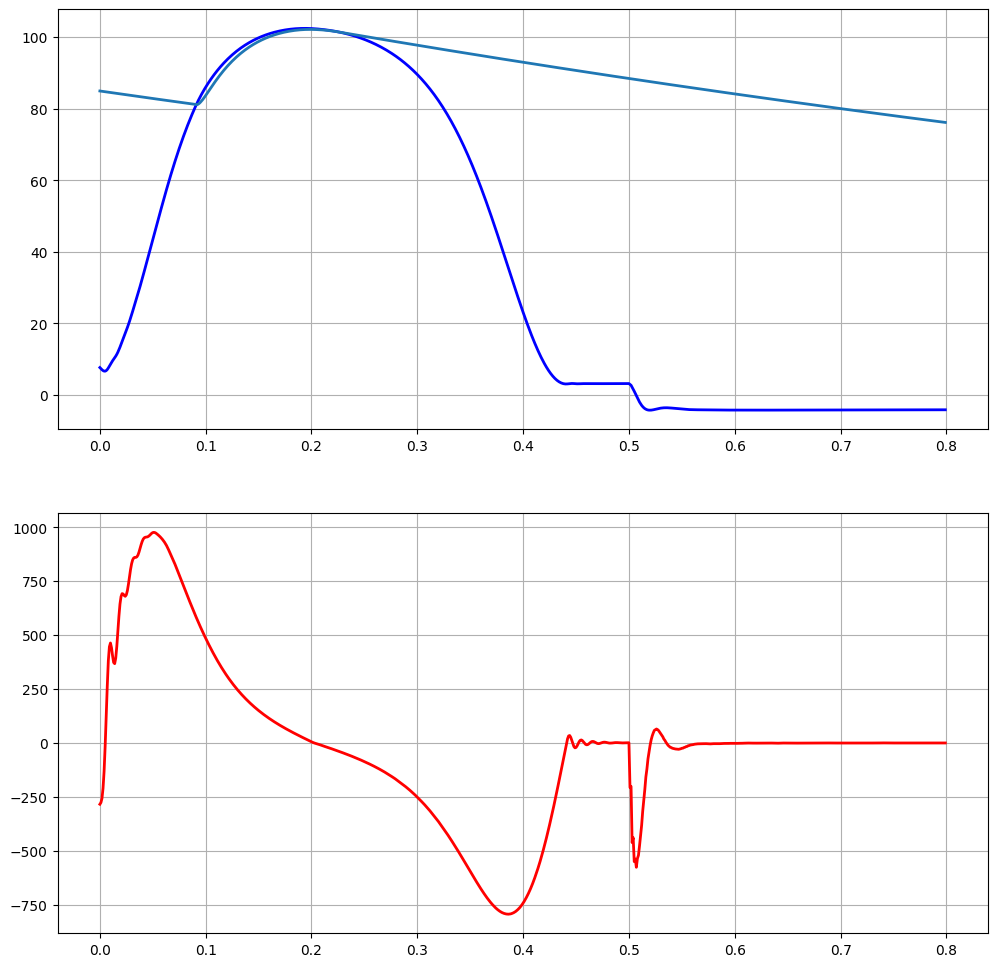

In [99]:
time_points = np.arange(0, duration, dt)
P_LV_values = np.zeros_like(time_points)
P_AO_values = np.zeros_like(time_points)
Q_LV_values = np.zeros_like(time_points)

P_LV_1_n = P_LV_0
P_AO_n = P_AO_0

for i, t in enumerate(time_points):
    Q_LV = fun_Q_LV(t + 0.3) 
    if P_AO_n > P_LV_1_n:
        P_LV, P_LV_1_n = Windkessel_1(Q_LV, P_LV_1_n, dt)
        P_AO = Windkessel_2(P_AO_n, dt)
        P_LV_n, P_AO_n = P_LV, P_AO
    else:
        P_LV_1, P_LV, Q_AO, P_AO = Windkessel_3(Q_LV, P_LV_1_n, P_AO_n, dt)
        P_LV_1_n, P_LV_n, Q_AO_n, P_AO_n = P_LV_1, P_LV, Q_AO, P_AO
    
    P_LV_values[i] = P_LV
    P_AO_values[i] = P_AO
    Q_LV_values[i] = Q_LV

# 绘制PLV曲线
plt.figure(figsize=(12, 12))

# PLV曲线
plt.subplot(2, 1, 1)
plt.plot(time_points, P_LV_values, 'b-', linewidth=2)
plt.plot(time_points, P_AO_values, linewidth=2)
# plt.xlabel('时间 (s)')
# plt.ylabel('P_LV (mmHg)')
# plt.title('左心室压力 (P_LV) 随时间变化曲线')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_points, Q_LV_values, 'r-', linewidth=2)
plt.grid(True)











In [94]:
print(P_LV_values[490])
print(len(P_LV_values))

6.0887629495121365
800
